In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2 as cv
# Изменять размер картинок до загрузки
from skimage.transform import resize
import skimage.io as io

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, SimpleRNN, LSTM, GRU, Conv2D, MaxPool2D
from keras.models import Sequential

from keras import backend
from keras import metrics
from keras import preprocessing
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
data_dir = os.path.join(os.pardir, os.pardir,'data')

x = []       
y = []
shape = (180, 320)#решейп это кто

for fullpath, dirs, files in os.walk(data_dir):
    if len(dirs) == 0:
        dirname = fullpath.split(os.path.sep)[-1]
        if dirname == 'open_img':
            for file in files:
                image = io.imread(os.path.join(fullpath,file))
                image = resize(image, shape)
                x.append(image)
        else:
            for file in files:
                image = io.imread(os.path.join(fullpath, file), as_gray=True)
                image = resize(image, shape)
                y.append(image)

x = np.array(x) # Картинки 
y = np.array(y) # Маски

(array([  624474.,  8557038., 22021261., 29349739., 26905463., 16789115.,
         7224598.,  3386956.,  1636123.,  1009233.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

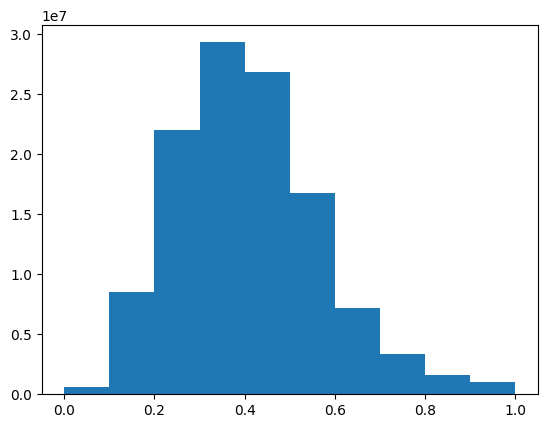

In [38]:
plt.hist(x.flatten())

In [6]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, BatchNormalization, add
from keras.models import Model

input_shape = x.shape[-3:]
inputs = Input(input_shape)

mm = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
mm = BatchNormalization()(mm)

previous_block_activation = mm

for filters in [64, 128, 256]:
    mm = Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu')(mm)
    mm = BatchNormalization()(mm)
    
    mm = Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu')(mm)
    mm = BatchNormalization()(mm)
    
    mm = MaxPool2D(3, strides=2, padding='same')(mm)

    residual = Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    mm = add([mm, residual])  # Add back residual
    previous_block_activation = mm  # Set aside next residual

for filters in [256, 128, 64]:
    mm = Conv2DTranspose(filters, 3, padding='same')(mm)
    mm = BatchNormalization()(mm)

    mm = Conv2DTranspose(filters, 3, padding='same')(mm)
    mm = BatchNormalization()(mm)
    
    mm = UpSampling2D()(mm)
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    mm = add([mm, residual])  # Add back residual
    previous_block_activation = mm  # Set aside next residual

# Add a per-pixel classification layer
outputs = Conv2D(1, 3, activation="softmax", padding="same")(mm)

# Define the model
model = Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 360, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 360, 640,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 640,  │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 360, 640,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 640,  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 360, 640,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 640,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 180, 320,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 180, 320,  │      2,112 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 180, 320,  │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 180, 320,  │     73,856 │ add_4[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 320,  │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 180, 320,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 320,  │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 90, 160,   │      8,320 │ add_4[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 90, 160,   │          0 │ max_pooling2d_4[

 Total params: 722,625 (2.76 MB)

 Trainable params: 721,025 (2.75 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [7]:
model.compile( optimizer="adam", loss="binary_crossentropy")

In [8]:
from sklearn.model_selection import train_test_split

seed = 42
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.9, random_state=seed)

In [9]:
model.fit(x_train, y_train, validation_split=0.2, epochs=5, verbose=1)

Epoch 1/5


C:\Users\Raz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 360, 640, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 457s 100s/step - loss: 15.1672 - val_loss: 15.0121
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 426s 105s/step - loss: 15.0472 - val_loss: 15.0121
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 462s 109s/step - loss: 15.1201 - val_loss: 15.0121
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 400s 93s/step - loss: 15.0560 - val_loss: 15.0121
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 386s 94s/step - loss: 15.2069 - val_loss: 15.0121


In [10]:
scores = model.evaluate(x_val, y_val)
scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 15.0388


15.03883171081543

In [11]:
predictions = model.predict(x_val)

C:\Users\Raz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (17, 360, 640, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


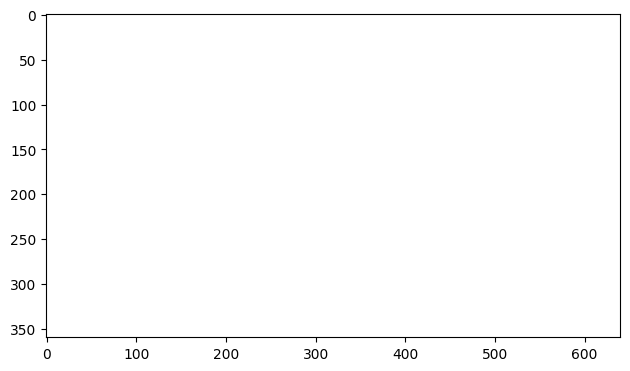

In [14]:
io.imshow(predictions[1])

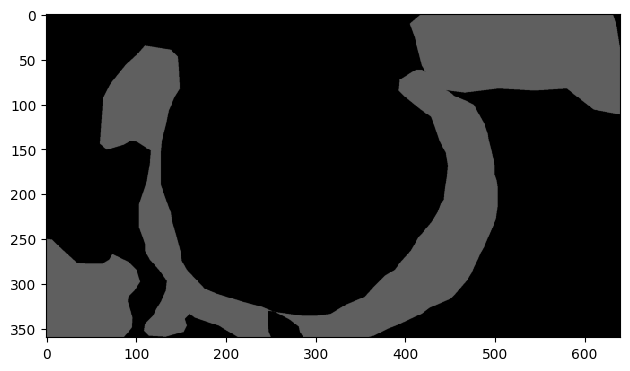

In [15]:
io.imshow(y_val[1])

In [44]:
''' Модель которая убивает кренель
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Resizing

input_shape = x.shape[-3:]
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

cropped_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block1_conv2').output)
cropped_model.trainable = False

input_part = Input(input_shape)
mm = cropped_model(input_part, training=False)

model = Model(inputs=input_part, outputs=mm)
model.summary(show_trainable=True)

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_50 (InputLayer) │ (None, 640, 360, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ functional_15 (Functional)  │ (None, 640, 360, 64)  │     38,720 │   N   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 38,720 (151.25 KB)

In [41]:
'''
features_train = model.predict(x_train)
features_train = features_train.reshape(-1, x_train.shape[3])
y_train = y_train.reshape(-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
